# Analysis of the Food Access Dataset 
Data taken from the United States Department of Agriculture Economic Research Service

The USDA defines a food desert as both low income and low access. Low access is defined as "a significant number or share of individuals in the tract is far from a supermarket." Low income is defined as "The tract’s poverty rate is 20 percent or greater; or the tract’s median family income is less than or equal to 80 percent of the State-wide median family income; or the tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income."

In [9]:
# standard imports

import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import xlrd

%matplotlib inline

In [10]:
plt.rcParams["figure.figsize"] = 10, 6
plt.rcParams["figure.dpi"] = 150

In [11]:
# import the excel file and create a dataframe
tracts_df = pd.read_excel('Houston tracts.xlsx')

In [12]:
# quick look at the tracts df
tracts_df.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,48225950100,Texas,Houston,0,4872,2081,0,0,0.000000,1,...,1117,3991,752,11,0,23,95,139,123,335
1,48225950200,Texas,Houston,0,1422,603,0,0,0.000000,0,...,349,1000,348,2,0,5,67,113,11,67
2,48225950300,Texas,Houston,1,3274,1194,0,338,0.103238,0,...,706,1788,1139,26,0,16,305,552,136,228
3,48225950400,Texas,Houston,1,3138,1252,0,0,0.000000,1,...,451,1100,1699,36,0,11,292,506,191,398
4,48225950500,Texas,Houston,0,4419,1834,0,112,0.025345,0,...,1076,3603,595,15,1,18,187,319,60,208


In [13]:
tracts_df.shape

(1108, 147)

We have 1108 entries with 147 features each

In [14]:
# import the excel of feature definitions
features_df = pd.read_excel('Food_Access_Features.xlsx')
features_df.head(10)

,Field,LongName,Description
0,CensusTract,Census tract,Census tract number
1,State,State,State name
2,County,County,County name
3,Urban,Urban tract,Flag for urban tract
4,POP2010,"Population, tract total",Population count from 2010 census
5,OHU2010,"Housing units, total",Occupied housing unit count from 2010 census
6,GroupQuartersFlag,"Group quarters, tract with high share",Flag for tract where >=67%
7,NUMGQTRS,"Group quarters, tract population residing in, ...",Count of tract population residing in group qu...
8,PCTGQTRS,"Group quarters, tract population residing in, ...",Percent of tract population residing in group ...
9,LILATracts_1And10,Low income and low access tract measured at 1 ...,Flag for food desert when considering low acce...


Text(0,0.5,'Number of Tracts')

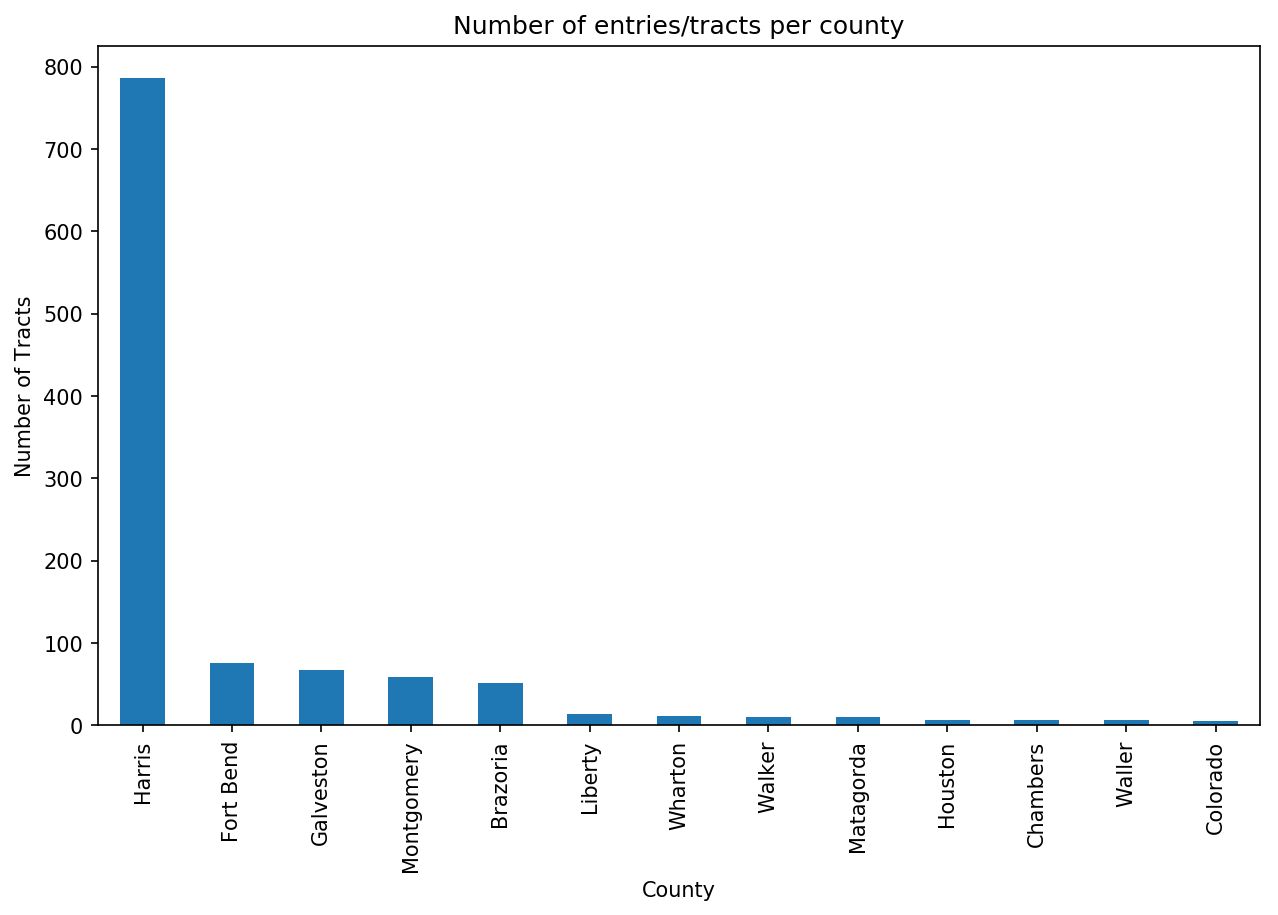

In [15]:
tracts_df.County.value_counts().sort_values(ascending=False).plot.bar()
plt.title("Number of entries/tracts per county");
plt.xlabel("County")
plt.ylabel("Number of Tracts")

There are a number of things we could try to predict here.

One option is to look at the total low access score based on the averages of the percentages of the population at 1/2, 1, 10, and 20 miles away from the nearest supermarket, supercenter, or large grocery store.

In [17]:
tracts_df['TLAPP'] =100/4 * (tracts_df['lapophalfshare'] + tracts_df['lapop1share'] + tracts_df['lapop10share'] + tracts_df['lapop20share'] )

With this, we now have an idea of how to measure whether a feature is correlated with low access. 

Text(0,0.5,'Avg Low Access Score by Population %')

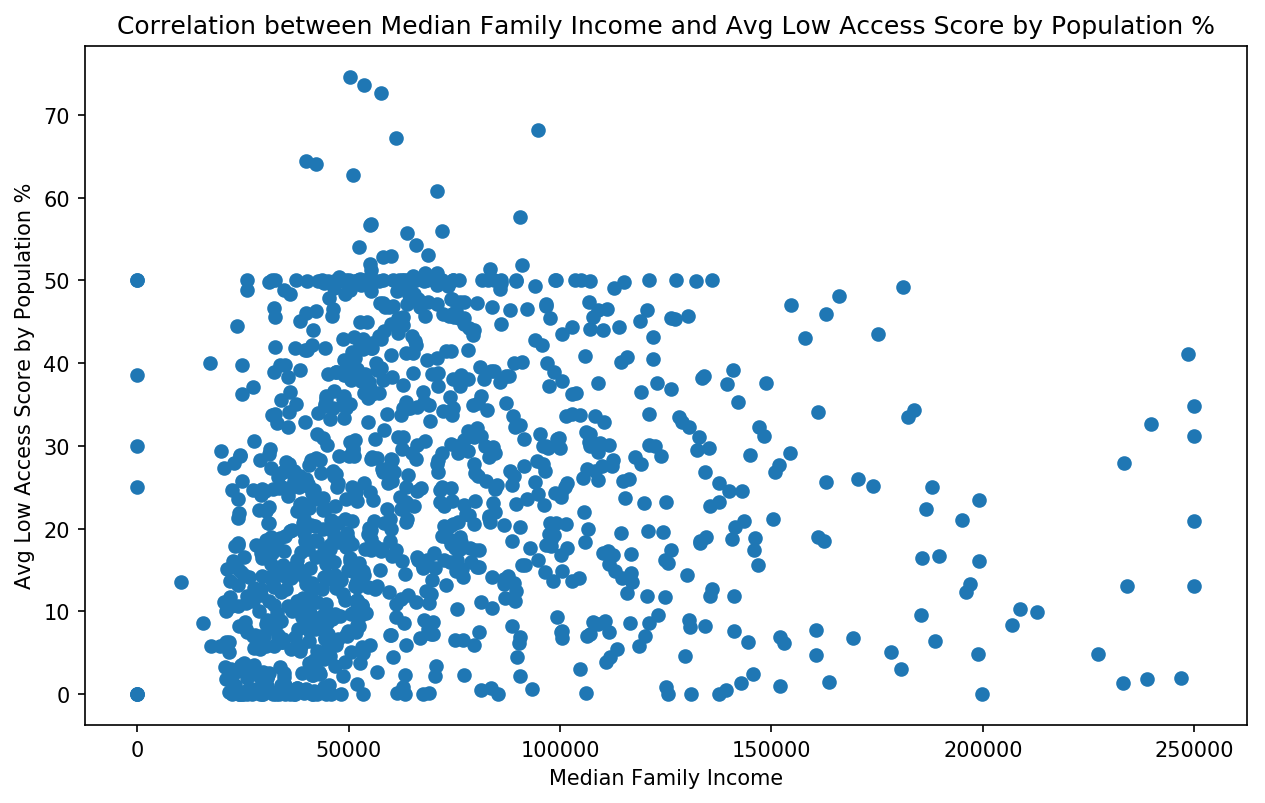

In [19]:
plt.scatter(tracts_df['MedianFamilyIncome'], tracts_df['TLAPP'])
plt.title("Correlation between Median Family Income and Avg Low Access Score by Population %");
plt.xlabel("Median Family Income")
plt.ylabel("Avg Low Access Score by Population %")

This seems like there could be some correlation. We can attempt to further examine the relationship between low income and access to food by building a model that is fitted on whether a tract is low income, the share of the tract living in poverty, and the median family income of the tract.

In [36]:
# split data
tracts_train, tracts_test = train_test_split(tracts_df, test_size = 0.3, train_size = 0.7 )
cols = ['LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome']
laImodel = LinearRegression() # low access/income model
laImodel.fit(tracts_train[cols],tracts_train['TLAPP'])
# training rmse
print('Logistic Regression Model on cols:' + str(cols))
y_pred_train = laImodel.predict(tracts_train[cols])
train_rmse = math.sqrt(mean_squared_error(tracts_train['TLAPP'], y_pred_train))
print('Training RMSE: ' + str(train_rmse))
# testing rmse
y_pred_test = laImodel.predict(tracts_test[cols])
test_rmse = math.sqrt(mean_squared_error(tracts_test['TLAPP'], y_pred_test))
print('Testing RMSE: ' + str(test_rmse))

Logistic Regression Model on cols:['LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome']
Training RMSE: 14.745882305385887
Testing RMSE: 15.312520633866496


This means that given whether a tract is low income, what the poverty rate in the tract is, and the median family income of the tract, the model can guess what percentage of the people livnig in the tract have low access to food within a range of about 15%. This seems like a somewhat reasonable. We can also explore some other options. 

Next, we can try logistic regression based on the total population and the population of differnet racial groups in the tract. 

In [37]:
cols = ['POP2010', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic']
laImodel2 = LinearRegression() # low access/income model
laImodel2.fit(tracts_train[cols],tracts_train['TLAPP'])
# training rmse
print('Logistic Regression Model on cols:' + str(cols))
y_pred_train = laImodel2.predict(tracts_train[cols])
train_rmse = math.sqrt(mean_squared_error(tracts_train['TLAPP'], y_pred_train))
print('Training RMSE: ' + str(train_rmse))
# testing rmse
y_pred_test = laImodel2.predict(tracts_test[cols])
test_rmse = math.sqrt(mean_squared_error(tracts_test['TLAPP'], y_pred_test))
print('Testing RMSE: ' + str(test_rmse))

Logistic Regression Model on cols:['POP2010', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic']
Training RMSE: 14.171454041236814
Testing RMSE: 15.179530515066666


The result is roughly the same as with the first model. 

In [38]:
cols = ['LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome','POP2010', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic']
laImodel3 = LinearRegression() # low access/income model
laImodel3.fit(tracts_train[cols],tracts_train['TLAPP'])
# training rmse
print('Logistic Regression Model on cols:' + str(cols))
y_pred_train = laImodel3.predict(tracts_train[cols])
train_rmse = math.sqrt(mean_squared_error(tracts_train['TLAPP'], y_pred_train))
print('Training RMSE: ' + str(train_rmse))
# testing rmse
y_pred_test = laImodel3.predict(tracts_test[cols])
test_rmse = math.sqrt(mean_squared_error(tracts_test['TLAPP'], y_pred_test))
print('Testing RMSE: ' + str(test_rmse))

Logistic Regression Model on cols:['LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome', 'POP2010', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic']
Training RMSE: 13.756557194311462
Testing RMSE: 14.733348494498442


Combining the two models makes the result marginally better, although when we add more features to the model we run the risk of overfitting to our training data. 